In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error as mse_score
from sklearn.multiclass import OneVsRestClassifier
from tensorflow.keras.datasets import mnist
from sklearn.svm import SVC
from sklearn.metrics.pairwise import pairwise_distances, polynomial_kernel, rbf_kernel
from sklearn.datasets import make_circles, make_moons

In [16]:
#load spambase data and scale 
spambase = fetch_ucirepo(id=94) 
    
X = spambase.data.features.values
X_spam = StandardScaler().fit_transform(X)
y_spam = np.squeeze(spambase.data.targets.values)
y_spam[y_spam==0] = -1

print(X_spam.shape)
print(y_spam.shape)

X_train_spam, X_test_spam, y_train_spam, y_test_spam = train_test_split(X_spam, y_spam, test_size=0.2, random_state = 42)

print(X_train_spam.shape)
print(y_train_spam.shape)
print(X_test_spam.shape)
print(y_test_spam.shape)

(4601, 57)
(4601,)
(3680, 57)
(3680,)
(921, 57)
(921,)


In [17]:
#load MNIST digits data with 200 extracted HARR features
X_train_digits = np.loadtxt("training_image.txt",delimiter=",")
X_test_digits = np.loadtxt("testing_image.txt",delimiter=",")
y_train_digits = np.loadtxt("training_label.txt",delimiter=",")
y_test_digits = np.loadtxt("testing_label.txt",delimiter=",")

print(X_train_digits.shape)
print(y_train_digits.shape)
print(X_test_digits.shape)
print(y_test_digits.shape)

(60000, 200)
(60000,)
(10000, 200)
(10000,)


# Question 1A

In [13]:
#train and test performance of the given SVM on spambase
def evaluate_kernel_spambase(svm, kernel_name):
    svm.fit(X_train_spam, y_train_spam)
    y_pred_train = svm.predict(X_train_spam)
    y_pred_test = svm.predict(X_test_spam)
    train_acc = accuracy_score(y_train_spam, y_pred_train)
    test_acc = accuracy_score(y_test_spam, y_pred_test)
    print("Kernel: {}, Train accuracy: {}, Test Accuracy: {}".format(kernel_name, train_acc, test_acc))
    
#using libsvm library
linear_svm = SVC(kernel='linear')
rbf_svm = SVC(kernel='rbf')
poly_svm = SVC(kernel='poly', degree=2)

evaluate_kernel_spambase(linear_svm, "linear")
evaluate_kernel_spambase(rbf_svm, "RBF")
evaluate_kernel_spambase(poly_svm, "Polynomial Degree 2")


Kernel: linear, Train accuracy: 0.9323369565217391, Test Accuracy: 0.9250814332247557
Kernel: RBF, Train accuracy: 0.9453804347826087, Test Accuracy: 0.9348534201954397
Kernel: Polynomial Degree 2, Train accuracy: 0.8614130434782609, Test Accuracy: 0.8393051031487514


# Question 1B

In [15]:
#train and test performance of the given SVM on MNIST HARR
def evaluate_kernel_mnist(svm, kernel_name):
    svm.fit(X_train_digits, y_train_digits)
    y_pred_train = svm.predict(X_train_digits)
    y_pred_test = svm.predict(X_test_digits)
    train_acc = accuracy_score(y_train_digits, y_pred_train)
    test_acc = accuracy_score(y_test_digits, y_pred_test)
    print("Kernel: {}, Train accuracy: {}, Test Accuracy: {}".format(kernel_name, train_acc, test_acc))
    
linear_svm = SVC(kernel='linear')
rbf_svm = SVC(kernel='rbf')
poly_svm = SVC(kernel='poly', degree=2)

evaluate_kernel_mnist(linear_svm, "linear")
evaluate_kernel_mnist(rbf_svm, "RBF")
evaluate_kernel_mnist(poly_svm, "Polynomial Degree 2")

Kernel: linear, Train accuracy: 0.9536833333333333, Test Accuracy: 0.9345
Kernel: RBF, Train accuracy: 0.9677, Test Accuracy: 0.9637
Kernel: Polynomial Degree 2, Train accuracy: 0.9629166666666666, Test Accuracy: 0.9594


# Question 2

In [62]:
class MyKernelSVMSMO:

    #tol is the error tolerance for convergence
    #max_iter is the max number of passes without convergence
    #C is the regularization parameter
    #kernel is {'linear', 'rbf', 'poly', 'sigmoid'}
    #sigma is the standard deviation of the gaussian in the rbf kernel
    #alpha is the scaling parameter in the polynomial and sigmoid kernel
    #c is the bias parameter in the polynomial and sigmoid kernel
    def __init__(self, tol: float = 1e-3, max_iter: int=100, C=1.0, kernel: str='linear', 
                 sigma: float=1.0, alpha: float=1.0, c: float=0, degree: int=3):
        self.tol = tol
        self.max_iter = max_iter
        self.C = C
        if kernel == 'poly':
            self.kernel = self._polynomial_kernel
            self.c = c
            self.degree = degree
            self.alpha = alpha
        elif kernel == 'rbf':
            self.kernel = self._rbf_kernel
            self.sigma = sigma
        elif kernel == 'sigmoid':
            self.kernel = self._sigmoid_kernel
            self.alpha = alpha
            self.c = c

        else:
            self.kernel = self._linear_kernel
        
        #initial feature matrix, shape (n, m)
        self.X = None 
        
        #targets, shape (n, )
        self.y = None # target
        
        #lagrangian multipliers, shape (n, )
        self.alphas = None
        
        #bias
        self.bias = 0
    
    #inner product of X and Y after implicit mapping to infinite gaussian space
    def _rbf_kernel(self, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        assert X.shape[-1] == Y.shape[-1]
        
        #handle 2 vectors
        if X.ndim == 1 and Y.ndim == 1:
            return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X - Y) ** 2)
        
        #handle matrix and vector, or matrix and matrix
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X[:, np.newaxis] - Y[np.newaxis, :], axis=-1) ** 2)
    
    #inner product of X and Y after implicit mapping to polynomial space
    def _polynomial_kernel(self, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        assert X.shape[-1] == Y.shape[-1]
        return ((self.alpha * X).dot(Y.T) + self.c) ** self.degree

    #inner product of X and Y after implicit mapping to 0-1 probability space
    def _sigmoid_kernel(self, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        assert X.shape[-1] == Y.shape[-1]
        return np.tanh((self.alpha * X).dot(Y.T) + self.c)

    #no feature transformations, just inner product of X and Y
    def _linear_kernel(self, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        return (X.dot(Y.T))
    
    #train SVM using SMO optimization
    def fit(self, X: np.ndarray, y: np.ndarray):

        n, m = X.shape
        assert y.shape[0] == n
        
        self.X = X
        self.y = y
        
        self.alphas = np.zeros((n, ))
        itr = 0
        while itr < self.max_iter:
            
            #track the number of lagrangians optimized this pass
            n_changed_alphas = 0
            
            #for each lagrangian and each training instance
            for i in range(n):
                
                #error for point i
                e_i = self._decision_function(X[i]) - y[i]
                
                #if the ith lagrangian does not yet satisfy KKT conditions within the given tolerance
                if (y[i] * e_i < -self.tol and self.alphas[i] < self.C) or (y[i] * e_i > self.tol and self.alphas[i] > 0):
                    
                    #pick random j != i
                    j = np.random.choice(np.delete(np.arange(n), i))
                    
                    #error for point j
                    e_j = self._decision_function(X[j]) - y[j]
                    
                    #store the ith and jth lagrangians before optimization
                    alpha_i_old = self.alphas[i]
                    alpha_j_old = self.alphas[j]
                    
                    '''
                    If y(i) != y(j), L = max(0, αj − αi), H = min(C, C + αj − αi)
                    If y(i) = y(j), L = max(0, αi + αj − C), H = min(C, αi + αj )
                    '''
                    
                    if y[i] != y[j]:
                        L = max(0, self.alphas[j] - self.alphas[i])
                        H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
                    else:
                        L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                        H = min(self.C, self.alphas[i] + self.alphas[j])
                        
                    if L == H:
                        continue
                    
                    #optimize the jth lagrangian
                    r = 2 * self.kernel(X[i], X[j]) - self.kernel(X[i], X[i]) - self.kernel(X[j], X[j])
                    
                    if r >= 0:
                        continue
                
                    self.alphas[j] -= (y[j] * (e_i - e_j) / r)
                    
                    #clip the new jth lagrangian between L and H
                    self.alphas[j] = np.clip(self.alphas[j], L, H)
                    
                    if abs(alpha_j_old - self.alphas[j]) < 1e-5:
                        continue
                    
                    #optimize the ith lagrangian
                    self.alphas[i] += (y[i] * y[j] * (alpha_j_old - self.alphas[j]))
                    
                    #update bias
                    b1 = self.bias - e_i - y[i] * (self.alphas[i] - alpha_i_old) * self.kernel(X[i], X[i]) - y[j] * (
                        self.alphas[j] - alpha_j_old) * self.kernel(X[i], X[j])
                    
                    b2 = self.bias - e_j - y[i] * (self.alphas[i] - alpha_i_old) * self.kernel(X[i], X[j]) - y[j] * (
                        self.alphas[j] - alpha_j_old) * self.kernel(X[j], X[j])
                    
                    if self.alphas[i] > 0 and self.alphas[i] < self.C:
                        self.bias = b1
                        
                    elif self.alphas[j] > 0 and self.alphas[j] < self.C:
                        self.bias = b2
                        
                    else:
                        self.bias = (b1 + b2) / 2
                        
                    n_changed_alphas += 1
                #endif
            #endfor
                    
            #check for convergence (i.e none of the alphas changed)
            if n_changed_alphas == 0:
                break
            else:
                itr += 1
        
                        
    #decision boundary for SMO
    def _decision_function(self, X) -> np.ndarray:
        assert X.shape[-1] == self.X.shape[-1]
        return (self.alphas * self.y).dot(self.kernel(self.X, X)) + self.bias

    #classify each point as -1 or 1 based on the sign of the decision score
    def predict(self, X) -> np.ndarray:
        return np.sign(self._decision_function(X))


 

In [63]:
my_smo_linear = MyKernelSVMSMO(kernel='linear')
my_smo_rbf = MyKernelSVMSMO(kernel='rbf')
my_smo_poly = MyKernelSVMSMO(kernel='poly', degree=2)
my_smo_sigmoid = MyKernelSVMSMO(kernel='sigmoid')

evaluate_kernel_spambase(my_smo_linear, "manual linear")
evaluate_kernel_spambase(my_smo_rbf, "manual RBF")
evaluate_kernel_spambase(my_smo_poly, "manual Polynomial Degree 2")
evaluate_kernel_spambase(my_smo_sigmoid, "manual sigmoid")

Kernel: manual linear, Train accuracy: 0.9119565217391304, Test Accuracy: 0.8968512486427795
Kernel: manual RBF, Train accuracy: 0.9932065217391305, Test Accuracy: 0.7741585233441911
Kernel: manual Polynomial Degree 2, Train accuracy: 0.9540760869565217, Test Accuracy: 0.8859934853420195
Kernel: manual sigmoid, Train accuracy: 0.7608695652173914, Test Accuracy: 0.7687296416938111


# Question 5

In [68]:
class MySVMOVR:
    def __init__(self, tol: float = 1e-3, max_iter: int=100, C=1.0, kernel: str='linear', 
                 sigma: float=1.0, alpha: float=1.0, c: float=0, degree: int=3):
        self.tol = tol
        self.max_iter = max_iter
        self.C = C
        self.kernel = kernel
        self.sigma = sigma
        self.alpha = alpha
        self.c = c
        self.degree = degree
        
    def fit(self, X, y):
        
        #how many distinct classes are in the target
        self.k = len(np.unique(y))
        
        #create one SVM for each class
        self.svms = []
        for i in range(self.k):
            svm = MyKernelSVMSMO(self.tol, self.max_iter, self.C, self.kernel, self.sigma, self.alpha, self.c, self.degree)
            self.svms.append(svm)
        
        #train svm i to distinguish class i vs everything else
        #svm i is a binary classifier that returns 1 (is i) or -1 (is not i)
        for i in range(self.k):
            
            y_new = np.zeros(y.shape)
            
            #all instances originlly labeled as class i are now labeled as 1 
            mask1 = y == i
            y_new[mask1] = 1
            
            #all instances not originally labeled as class i are now labeled as -1
            mask2 = y != i
            y_new[mask2] = -1
            
            self.svms[i].fit(X, y_new)
        
             
    def predict_proba(self, X):
        
        #shape (n, k) - the ith SVM predicts (n, ) probabilities for class i
        score = np.stack([self.svms[i]._decision_function(X) for i in range(self.k)], axis=1)
        
        #normalize all k probability scores so they sum to 1
        return F.softmax(torch.Tensor(score), dim=1).numpy()
    
    def predict(self, X):
        #shape (n, ) - for each instance predict the class whose SVM returned the highest probability
        return np.argmax(self.predict_proba(X), axis=1)
        
    
        

In [80]:
#train and test performance of the given SVM on 10% subset of MNIST HARR
def evaluate_kernel_partial_mnist(svm, kernel_name):
    svm.fit(X_train_digits[:6000], y_train_digits[:6000])
    y_pred_train = svm.predict(X_train_digits[:6000])
    y_pred_test = svm.predict(X_test_digits)
    train_acc = accuracy_score(y_train_digits[:6000], y_pred_train)
    test_acc = accuracy_score(y_test_digits, y_pred_test)
    print("Kernel: {}, Train accuracy: {}, Test Accuracy: {}".format(kernel_name, train_acc, test_acc))

linear_ovr_svm = MySVMOVR(kernel='linear', max_iter=300)

rbf_ovr_svm = MySVMOVR(kernel='rbf')

poly_ovr_svm = MySVMOVR(kernel='poly', degree=2)


evaluate_kernel_partial_mnist(linear_ovr_svm, 'linear')
#evaluate_kernel_partial_mnist(rbf_ovr_svm, 'rbf')
#evaluate_kernel_partial_mnist(poly_ovr_svm, 'polynomial degree 2')

Kernel: linear, Train accuracy: 0.8706666666666667, Test Accuracy: 0.8372


# Question 3

In [54]:
#with cosine distance

class MyKNN:
    
    def __init__(self, k: int, radius: int = None, distance_func: str = 'cosine', sigma: float=1.0, alpha: float=1.0, c: float=0, degree: int=2):
        self.k = k
        self.radius = radius
        self.distance_func = distance_func 
        self.sigma = sigma
        self.alpha = alpha
        self.c = c
        self.degree = degree
    
        
    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        assert X_train.shape[0] == y_train.shape[0]
        self.n, self.m = X_train.shape
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        
            
        #pre-compute pairwise distances between each test point and each training point
        if self.distance_func == 'cosine':
            pd = pairwise_distances(X_test, self.X_train, metric='cosine')
        elif self.distance_func == 'rbf':
            pd = rbf_kernel(X_test, self.X_train, gamma=self.sigma)
        elif self.distance_func == 'poly':
            pd = polynomial_kernel(X_test, self.X_train,  degree=self.degree, gamma = self.alpha, coef0=self.c)
        else:
            pd = pairwise_distances(X_test, self.X_train)

        predictions = []
        #for each test point
        for i in range(X_test.shape[0]):

            #row i of the pairwise distance matrix is the similarities between test point i and all training points
            similarities = pd[i, :]
            
            if self.radius is None:

                #sort indices by ascending order of distance
                similarities_labels_sorted = np.argsort(similarities)

                #the first k elements of the sorted list of indices are the k nearest neighbors to this test point
                knn_labels = self.y_train[similarities_labels_sorted][:self.k]

                #majority vote: whatever label is most common in the k nearest neighbors, assign to this test point
                labels, counts = np.unique(knn_labels, return_counts=True)
                yi = labels[np.argmax(counts)]
                predictions.append(yi)
                
            else:
                
                #only training points that are within a set radius of the test point i
                mask = similarities <= self.radius
                
                if np.sum(mask) == 0:
                    predictions.append(-1)
                    continue
                                
                #labels of all training points that fall within the radius
                radius_labels = self.y_train[mask]
                
                #majority vote: whatever label is most common in the radius, assign to this test point
                labels, counts = np.unique(radius_labels, return_counts=True)
                yi = labels[np.argmax(counts)]
                predictions.append(yi)
                
        return np.array(predictions)
            
    

## Part A

In [46]:
#on spambase

for distance_func in ['euclidian']:
    for k in [1,3,7]:
        
        print("Kernel = {}, k={}".format(distance_func, k))
        knn = MyKNN(k, None, distance_func)
        knn.fit(X_train_spam, y_train_spam)
        
        y_train_pred = knn.predict(X_train_spam)
        y_test_pred = knn.predict(X_test_spam)
        
        train_acc = accuracy_score(y_train_spam, y_train_pred)
        test_acc = accuracy_score(y_test_spam, y_test_pred)
        
        print("Train accuracy = {}, test accuracy = {}".format(train_acc, test_acc))
        


Kernel = euclidian, k=1
Train accuracy = 0.9997282608695652, test accuracy = 0.8957654723127035
Kernel = euclidian, k=3
Train accuracy = 0.9502717391304348, test accuracy = 0.8935939196525515
Kernel = euclidian, k=7
Train accuracy = 0.9282608695652174, test accuracy = 0.8957654723127035


In [60]:
#on MNIST digits

for distance_func in ['cosine','rbf', 'poly']:
    for k in [1,3,7]:
        
        print("Kernel = {}, k={}".format(distance_func, k))
        knn = MyKNN(k, None, distance_func)
        knn.fit(X_train_digits[:10000], y_train_digits[:10000])
        
        y_train_pred = knn.predict(X_train_digits[:10000])
        y_test_pred = knn.predict(X_test_digits)
        
        train_acc = accuracy_score(y_train_digits[:10000], y_train_pred)
        test_acc = accuracy_score(y_test_digits, y_test_pred)
        
        print("Train accuracy = {}, test accuracy = {}".format(train_acc, test_acc))

Kernel = cosine, k=1
Train accuracy = 1.0, test accuracy = 0.9167
Kernel = cosine, k=3
Train accuracy = 0.9605, test accuracy = 0.9214
Kernel = cosine, k=7
Train accuracy = 0.9402, test accuracy = 0.9194
Kernel = rbf, k=1
Train accuracy = 0.0862, test accuracy = 0.0892
Kernel = rbf, k=3
Train accuracy = 0.0937, test accuracy = 0.0898
Kernel = rbf, k=7
Train accuracy = 0.0921, test accuracy = 0.0891
Kernel = poly, k=1
Train accuracy = 0.0289, test accuracy = 0.0283
Kernel = poly, k=3
Train accuracy = 0.0299, test accuracy = 0.0278
Kernel = poly, k=7
Train accuracy = 0.0269, test accuracy = 0.0248


## Part B

In [59]:
#on spambase

for distance_func in ['euclidian', 'cosine']:
    for r in [0.5, 1, 1.5, 2]:
        
        print("Kernel = {}, radius={}".format(distance_func, r))
        knn = MyKNN(1, r, distance_func)
        knn.fit(X_train_spam, y_train_spam)
        
        y_train_pred = knn.predict(X_train_spam)
        y_test_pred = knn.predict(X_test_spam)
        
        train_acc = accuracy_score(y_train_spam, y_train_pred)
        test_acc = accuracy_score(y_test_spam, y_test_pred)
        
        print("Train accuracy = {}, test accuracy = {}".format(train_acc, test_acc))
        


Kernel = euclidian, radius=0.5
Train accuracy = 0.9959239130434783, test accuracy = 0.745928338762215
Kernel = euclidian, radius=1
Train accuracy = 0.9918478260869565, test accuracy = 0.7654723127035831
Kernel = euclidian, radius=1.5
Train accuracy = 0.9855978260869566, test accuracy = 0.7817589576547231
Kernel = euclidian, radius=2
Train accuracy = 0.975, test accuracy = 0.7926167209554832
Kernel = cosine, radius=0.5
Train accuracy = 0.9040760869565218, test accuracy = 0.9033659066232356
Kernel = cosine, radius=1
Train accuracy = 0.866304347826087, test accuracy = 0.8599348534201955
Kernel = cosine, radius=1.5
Train accuracy = 0.6133152173913043, test accuracy = 0.5765472312703583
Kernel = cosine, radius=2
Train accuracy = 0.6133152173913043, test accuracy = 0.5765472312703583


## Part C

In [98]:
#load spambase data and scale 
spambase = fetch_ucirepo(id=94) 
    
X = spambase.data.features.values
X_spam = StandardScaler().fit_transform(X)
y_spam = np.squeeze(spambase.data.targets.values)

print(X_spam.shape)
print(y_spam.shape)

X_train_spam, X_test_spam, y_train_spam, y_test_spam = train_test_split(X_spam, y_spam, test_size=0.2, random_state = 42)

print(X_train_spam.shape)
print(y_train_spam.shape)
print(X_test_spam.shape)
print(y_test_spam.shape)

(4601, 57)
(4601,)
(3680, 57)
(3680,)
(921, 57)
(921,)


In [102]:
class MyKDE:
    
    #kernel is {'linear', 'rbf', 'poly', 'sigmoid'}
    #sigma is the standard deviation of the gaussian in the rbf kernel
    #alpha is the scaling parameter in the polynomial and sigmoid kernel
    #c is the bias parameter in the polynomial and sigmoid kernel
    def __init__(self, kernel: str='linear', sigma: float=1.0, alpha: float=1.0, c: float=0, degree: int=2):
        if kernel == 'poly':
            self.kernel = self._polynomial_kernel
            self.c = c
            self.degree = degree
            self.alpha = alpha
        elif kernel == 'rbf':
            self.kernel = self._rbf_kernel
            self.sigma = sigma
        elif kernel == 'sigmoid':
            self.kernel = self._sigmoid_kernel
            self.alpha = alpha
            self.c = c

        else:
            self.kernel = self._linear_kernel
     
    
    #inner product of X and Y after implicit mapping to infinite gaussian space
    def _rbf_kernel(self, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        assert X.shape[-1] == Y.shape[-1]
        
        #handle 2 vectors
        if X.ndim == 1 and Y.ndim == 1:
            return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X - Y) ** 2)
        
        #handle matrix and vector, or matrix and matrix
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X[:, np.newaxis] - Y[np.newaxis, :], axis=-1) ** 2)
    
    #inner product of X and Y after implicit mapping to polynomial space
    def _polynomial_kernel(self, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        assert X.shape[-1] == Y.shape[-1]
        return ((self.alpha * X).dot(Y.T) + self.c) ** self.degree

    #inner product of X and Y after implicit mapping to 0-1 probability space
    def _sigmoid_kernel(self, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        assert X.shape[-1] == Y.shape[-1]
        return np.tanh((self.alpha * X).dot(Y.T) + self.c)

    #no feature transformations, just inner product of X and Y
    def _linear_kernel(self, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        return (X.dot(Y.T))
    
    def describe(self):
        if self.kernel == self._rbf_kernel:
            return "RBF kernel, sigma = {}".format(self.sigma)
        elif self.kernel == self._polynomial_kernel:
            return "Polynomial kernel, degree = {}, scale = {}, shift = {}".format(self.degree, self.alpha, self.c)
        elif self.kernel == self._sigmoid_kernel:
            return "Sigmoid kernel, scale = {}, shift = {}".format(self.alpha, self.c)
        else:
            return "Linear kernel"
        
        
    def fit(self, X, y):
        assert X.shape[0] == y.shape[0]
        self.n, self.m = X.shape
        self.X = X
        self.y = y        
        labels, self.counts = np.unique(self.y, return_counts=True)
        
        self.n_classes = len(labels)
        self.priors = self.counts / self.n
        
    def predict(self, X):
        
        probs = np.zeros((X.shape[0], self.n_classes))
        
        for k in range(self.n_classes):
            
            K = self.kernel(X, self.X[self.y == k, :])
                                    
            prob_k = np.log(self.priors[k] * (1/self.counts[k]) * np.sum(K, axis=1) + 1e-10)
            
            probs[:, k] = prob_k
        
        predictions = np.argmax(probs, axis=1)
                
        return predictions
        
    

In [103]:
#on spambase

for kernel in ['rbf', 'poly']:
            
    kde = MyKDE(kernel)
    
    print(kde.describe())
    
    kde.fit(X_train_spam, y_train_spam)

    y_train_pred = kde.predict(X_train_spam)
    y_test_pred = kde.predict(X_test_spam)

    train_acc = accuracy_score(y_train_spam, y_train_pred)
    test_acc = accuracy_score(y_test_spam, y_test_pred)

    print("Train accuracy = {}, test accuracy = {}".format(train_acc, test_acc))

RBF kernel, sigma = 1.0
Train accuracy = 0.9866847826086956, test accuracy = 0.9055374592833876
Polynomial kernel, degree = 2, scale = 1.0, shift = 0
Train accuracy = 0.8182065217391304, test accuracy = 0.8078175895765473


In [108]:
#on MNIST digits

for kernel in ['rbf', 'poly']:
            
    kde = MyKDE(kernel)
    
    print(kde.describe())
    
    kde.fit(X_train_digits[:4000], y_train_digits[:4000])

    y_train_pred = kde.predict(X_train_digits[:4000])
    y_test_pred = kde.predict(X_test_digits)

    train_acc = accuracy_score(y_train_digits[:4000], y_train_pred)
    test_acc = accuracy_score(y_test_digits, y_test_pred)

    print("Train accuracy = {}, test accuracy = {}".format(train_acc, test_acc))

RBF kernel, sigma = 1.0
Train accuracy = 1.0, test accuracy = 0.0993
Polynomial kernel, degree = 2, scale = 1.0, shift = 0
Train accuracy = 0.597, test accuracy = 0.5796


# Question 4

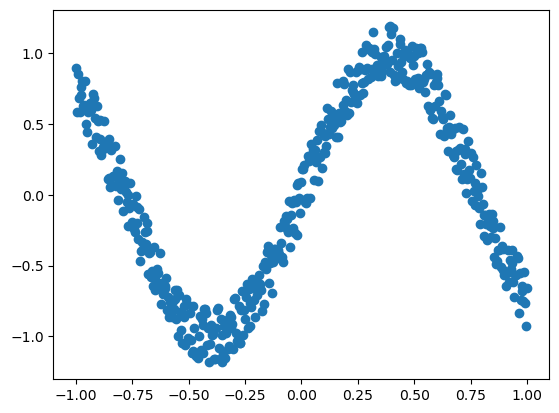

In [24]:
wave_X = np.linspace(-1, 1, 500)

wave_y = np.sin(4 * sine_X) + np.random.uniform(-0.2, 0.2, 500)

plt.scatter(wave_X, wave_y)
plt.show()

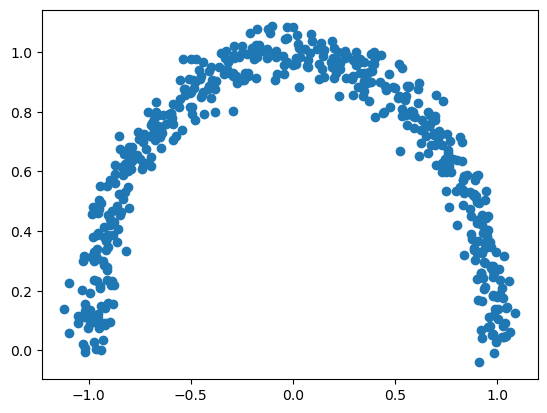

In [25]:
moons, labels = make_moons(n_samples=1000, noise=0.05)
moons_X = moons[labels==0,0]
moons_y = moons[labels==0,1]
plt.scatter(moons_X, moons_y)
plt.show()

In [26]:
class MyKernelRidge:

    #kernel is {'linear', 'rbf', 'poly', 'sigmoid'}
    #sigma is the standard deviation of the gaussian in the rbf kernel
    #alpha is the scaling parameter in the polynomial and sigmoid kernel
    #c is the bias parameter in the polynomial and sigmoid kernel
    def __init__(self, lmbda: float=0, kernel: str='linear', sigma: float=1.0, alpha: float=1.0, c: float=0, degree: int=3):
        self.lmbda = lmbda
        if kernel == 'poly':
            self.kernel = self._polynomial_kernel
            self.c = c
            self.degree = degree
            self.alpha = alpha
        elif kernel == 'rbf':
            self.kernel = self._rbf_kernel
            self.sigma = sigma
        elif kernel == 'sigmoid':
            self.kernel = self._sigmoid_kernel
            self.alpha = alpha
            self.c = c

        else:
            self.kernel = self._linear_kernel
     
    
    #inner product of X and Y after implicit mapping to infinite gaussian space
    def _rbf_kernel(self, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        assert X.shape[-1] == Y.shape[-1]
        
        #handle 2 vectors
        if X.ndim == 1 and Y.ndim == 1:
            return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X - Y) ** 2)
        
        #handle matrix and vector, or matrix and matrix
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X[:, np.newaxis] - Y[np.newaxis, :], axis=-1) ** 2)
    
    #inner product of X and Y after implicit mapping to polynomial space
    def _polynomial_kernel(self, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        assert X.shape[-1] == Y.shape[-1]
        return ((self.alpha * X).dot(Y.T) + self.c) ** self.degree

    #inner product of X and Y after implicit mapping to 0-1 probability space
    def _sigmoid_kernel(self, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        assert X.shape[-1] == Y.shape[-1]
        return np.tanh((self.alpha * X).dot(Y.T) + self.c)

    #no feature transformations, just inner product of X and Y
    def _linear_kernel(self, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        return (X.dot(Y.T))
    
    def describe(self):
        if self.kernel == self._rbf_kernel:
            return "RBF kernel, sigma = {}".format(self.sigma)
        elif self.kernel == self._polynomial_kernel:
            return "Polynomial kernel, degree = {}, scale = {}, shift = {}".format(self.degree, self.alpha, self.c)
        elif self.kernel == self._sigmoid_kernel:
            return "Sigmoid kernel, scale = {}, shift = {}".format(self.alpha, self.c)
        else:
            return "Linear kernel"

    
    #use kernel trick to find f*
    def fit(self, X: np.ndarray, y: np.ndarray):

        n, m = X.shape
        assert y.shape[0] == n
    
        self.X = X
        self.y = y
        
        l_I = np.eye(n) * self.lmbda

        self.alphas = np.linalg.inv(self.kernel(self.X, self.X) + l_I) @ self.y


    def predict(self, X) -> np.ndarray:
        return self.kernel(X, self.X) @ self.alphas 



In [27]:
def evaluate_kernel_ridge(X, y, kernel_ridge):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    kernel_ridge.fit(X_train.reshape(-1, 1), y_train)

    y_pred_train = kernel_ridge.predict(X_train.reshape(-1, 1))
    
    y_pred_test = kernel_ridge.predict(X_test.reshape(-1, 1))

    mse_train = mse_score(y_train, y_pred_train)
    mse_test = mse_score(y_test, y_pred_test)

    print(kernel_ridge.describe() + ", lambda = {}".format(kernel_ridge.lmbda))
    plt.scatter(X_train, y_train, label = 'actual train', c='b')
    plt.scatter(X_train, y_pred_train, label = 'predicted train', c='r')
    plt.title("Train MSE = {}".format(mse_train))
    plt.legend()
    plt.show()
    
    plt.scatter(X_test, y_test, label = 'actual test', c='b')
    plt.scatter(X_test, y_pred_test, label = 'predicted test', c='r')
    plt.title("Test MSE = {}".format(mse_test))
    plt.legend()
    plt.show()

RBF kernel, sigma = 0.001, lambda = 0.05


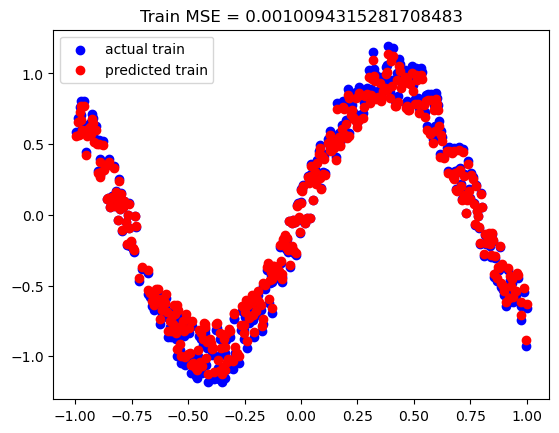

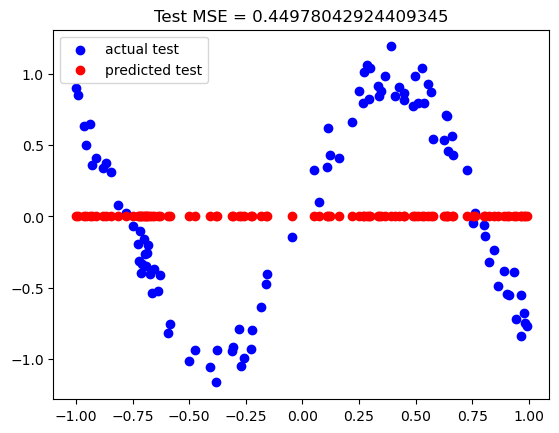

In [28]:
wave_rbf_kernel_ridge = MyKernelRidge(lmbda=0.05, kernel='rbf', sigma=0.001)

evaluate_kernel_ridge(wave_X, wave_y, wave_rbf_kernel_ridge)

RBF kernel, sigma = 0.001, lambda = 0.05


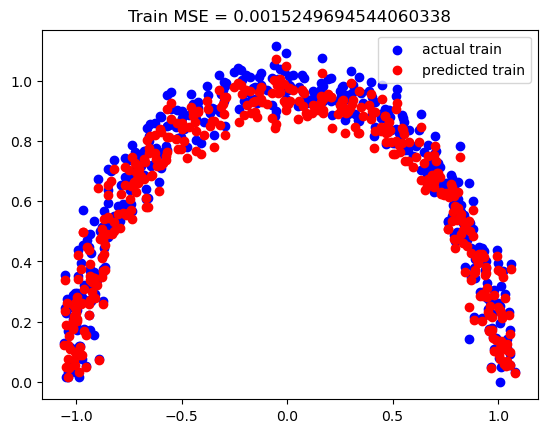

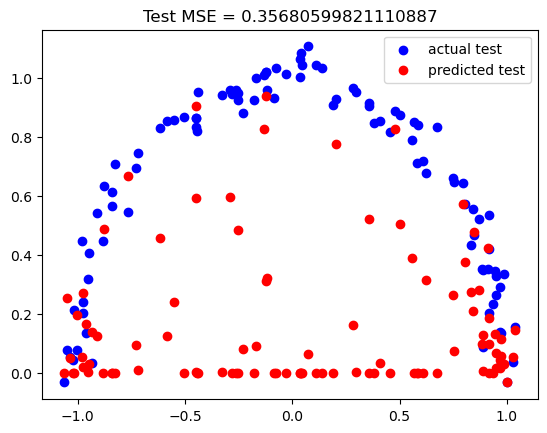

In [62]:
moons_rbf_kernel_ridge = MyKernelRidge(lmbda=0.05, kernel='rbf', sigma=0.001)

evaluate_kernel_ridge(moons_X, moons_y, moons_rbf_kernel_ridge)

Polynomial kernel, degree = 3, scale = 0.6, shift = 0.2, lambda = 0.05


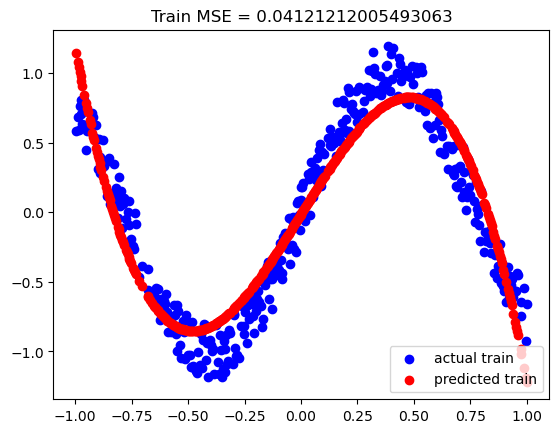

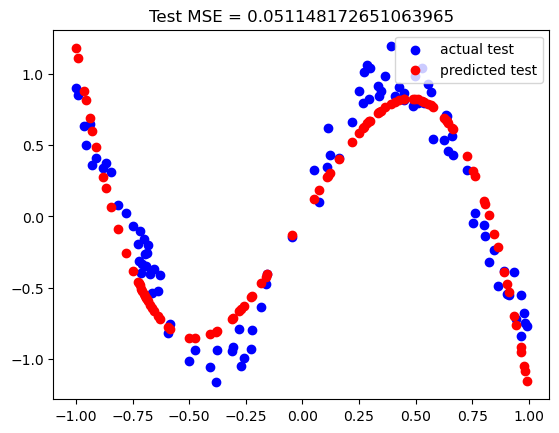

In [39]:
wave_poly_kernel_ridge = MyKernelRidge(lmbda=0.05, kernel='poly', degree=3, alpha=0.6, c=0.2)

evaluate_kernel_ridge(wave_X, wave_y, wave_poly_kernel_ridge)

Polynomial kernel, degree = 3, scale = 0.3, shift = 0.2, lambda = 0.05


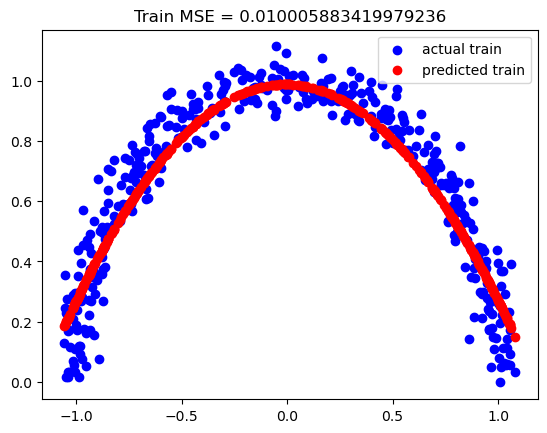

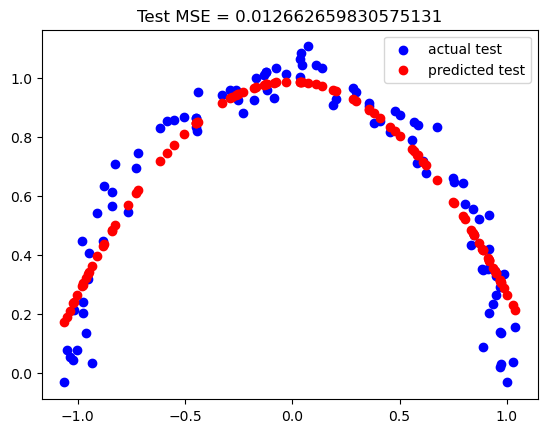

In [79]:
moons_poly_kernel_ridge = MyKernelRidge(lmbda=0.05, kernel='poly', degree=3, alpha=0.3, c=0.2)

evaluate_kernel_ridge(moons_X, moons_y, moons_poly_kernel_ridge)